In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import beta

from selfpeptide.model.binding_affinity_classifier import Peptide_HLA_BindingClassifier
from selfpeptide.model.components import ResMLP_Network
from selfpeptide.utils.data_utils import load_immunogenicity_dataframes, filter_peptide_dataset, load_immunogenicity_dataframes_jointseqs
from selfpeptide.utils.constants import *

In [5]:
# with open("../trained_models/BindingModels/solar-sweep-1/config.json", "r") as f:
#     binding_config = json.load(f)
# for k in binding_config.keys():
#     if not isinstance(binding_config[k], str):
#         continue
#     if "/home/gvisona/SelfPeptides" in binding_config[k]:
#         binding_config[k] = binding_config[k].replace("/home/gvisona/SelfPeptides", "/home/gvisona/Projects/SelfPeptides")
#     if "/fast/gvisona/SelfPeptides" in binding_config[k]:
#         binding_config[k] = binding_config[k].replace("/fast/gvisona/SelfPeptides", "/home/gvisona/Projects/SelfPeptides")
# binding_config

In [6]:
imm_config = {}
config = {}
config["immunogenicity_df"] = "/home/gvisona/Projects/SelfPeptides/processed_data/Immunogenicity/Processed_TCell_IEDB_beta_summed.csv"
config["pseudo_seq_file"] = "/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_pseudoseqs_T5/hla_pseudoseq_mapping.csv"
config["hla_prot_seq_file"] = "/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_mapping.csv"
config["binding_affinity_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/DHLAP_binding_affinity_data.csv'
config["binding_model_checkpoint"] = '/home/gvisona/Projects/SelfPeptides/trained_models/binding_model/checkpoints/001_checkpoint.pt'
config["binding_model_config"] = '/home/gvisona/Projects/SelfPeptides/trained_models/binding_model/config.json'
config["dhlap_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Immunogenicity/DHLAP_immunogenicity_data.csv'
config["test_size"] = 0.15
config["val_size"] = 0.1
config["seed"]= 0


In [7]:
# split_data=True
# def load_immunogenicity_dataframes_proteinseq(config, split_data=True):
#     ps_df = pd.read_csv(config['pseudo_seq_file'])
#     prot_df = pd.read_csv(config['hla_prot_seq_file'])


#     hla_pseq_mapping = dict(ps_df[["HLA", "sequence"]].values)
#     hla_prot_mapping = dict(prot_df[["HLA", "sequence"]].values)

#     # ps_df = pd.read_csv(config['pseudo_seq_file'], sep="\t")
#     # hla_mapping = dict(ps_df[["HLA", "sequence"]].values)

#     res_df = None

#     imm_df = pd.read_csv(config['immunogenicity_df'])
#     imm_df["Allele Pseudo-sequence"] = imm_df["HLA"].str.replace("*", "", regex=False).map(hla_pseq_mapping)
#     imm_df["Allele Protein sequence"] = imm_df["HLA"].str.replace("*", "", regex=False).map(hla_prot_mapping)

#     imm_df = imm_df.dropna(subset=["Peptide", "Allele Pseudo-sequence"])
#     imm_df["Target"] = (imm_df["Qualitative Measurement"]!="Negative").astype(int).values
#     imm_df["Sample"] = imm_df["Peptide"] + "_" + imm_df["HLA"]


#     imm_df["Peptide Length"] = imm_df["Peptide"].str.len()
#     imm_df = imm_df[(imm_df["Peptide Length"]>=MIN_PEPTIDE_LEN)&(imm_df["Peptide Length"]<=MAX_PEPTIDE_LEN)]

#     imm_df = imm_df.sort_values(by="Number of Subjects Tested", 
#                                           ascending=False).drop_duplicates(
#                                               "Sample", keep="first").reset_index(drop=True)

#     min_subjects_tested = config.get("min_subjects_tested", 1)
#     imm_df = imm_df[imm_df["Number of Subjects Tested"]>=min_subjects_tested]


#     imm_df = imm_df.dropna()

#     imm_df = filter_peptide_dataset(imm_df, sorted_vocabulary)
#     hla_filter = config.get("hla_filter", None)
#     if hla_filter is not None:
#         imm_df = imm_df[imm_df["HLA"].str.startswith(hla_filter)]
#     imm_df = imm_df.reset_index(drop=True)

#     a = imm_df["Alpha"]
#     b = imm_df["Beta"]
#     imm_df["Distr. Mean"] = a/(a+b)
#     imm_df["Distr. Variance"] = a*b/((a+b)**2 * (a+b+1))
#     imm_df["Distr. Mode"] = (a-1)/(a+b-2)
#     imm_df["Distr. Precision"] = a+b

#     imm_df["Stratification_index"] = imm_df["HLA"] + "_" + imm_df["Target"].astype(str)

#     ix = imm_df["Stratification_index"].value_counts()
#     low_count_labels = ix[ix<3].index

#     res_df = imm_df[imm_df["Stratification_index"].isin(low_count_labels)]
#     imm_df = imm_df[~imm_df["Stratification_index"].isin(low_count_labels)]

#     test_size = config.get("test_size", 0.15)
#     trainval_df, test_df = train_test_split(imm_df, test_size=test_size, stratify=imm_df["Stratification_index"], random_state=config['seed'], shuffle=True)
#     val_size = config.get("val_size", 0.1)
#     train_df, val_df = train_test_split(trainval_df, test_size=val_size, stratify=trainval_df["Stratification_index"], random_state=config['seed'], shuffle=True)
#     if res_df is not None:
#         train_df = pd.concat([train_df, res_df])


#     dhlap_imm_df = pd.read_csv(config['dhlap_df'])
#     dhlap_imm_df["Allele Pseudo-sequence"] = dhlap_imm_df["HLA"].str.replace("*", "", regex=False).map(hla_pseq_mapping)
#     dhlap_imm_df["Allele Protein sequence"] = dhlap_imm_df["HLA"].str.replace("*", "", regex=False).map(hla_prot_mapping)
#     dhlap_imm_df = dhlap_imm_df.dropna()

#     # Filter DHLAP to keep only samples not trained on  
#     iedb_samples = set(tuple(x) for x in trainval_df[["Peptide", "HLA"]].values).union(set(tuple(x) for x in res_df[["Peptide", "HLA"]].values))
#     dhlap_samples = set(tuple(x) for x in dhlap_imm_df[["Peptide", "HLA"]].values)
#     dhlap_imm_df = dhlap_imm_df[dhlap_imm_df[["Peptide", "HLA"]].apply(tuple, 1).isin(dhlap_samples.difference(iedb_samples))]

#     # dhlap_imm_df = dhlap_imm_df.merge(blast_df, left_on="Peptide", right_on="Peptide")
#     dhlap_imm_df = dhlap_imm_df.dropna()
#     dhlap_imm_df = filter_peptide_dataset(dhlap_imm_df, amino_acids)
#     if dhlap_imm_df is not None and hla_filter is not None:
#         dhlap_imm_df = dhlap_imm_df[dhlap_imm_df["HLA"].str.startswith(hla_filter)]
#     dhlap_imm_df = dhlap_imm_df.reset_index(drop=True)

#     if split_data:
#         print("IEDB N. training samples: {}".format(len(train_df)))
#         print("IEDB N. val samples: {}".format(len(val_df)))
#         print("IEDB N. test samples: {}".format(len(test_df)))

#         return train_df, val_df, test_df, dhlap_imm_df
#     else:
#         return imm_beta_df, dhlap_imm_df

    



In [8]:
train_df, val_df, test_df, dhlap_imm_df = load_immunogenicity_dataframes_jointseqs(config, True)
train_df

IEDB N. training samples: 21435
IEDB N. val samples: 2373
IEDB N. test samples: 4187


,Peptide,HLA,Qualitative Measurement,Peptide length,Number of Subjects Tested,Number of Subjects Positive,Alpha,Beta,Allele Pseudo-sequence,Allele Protein sequence,Target,Sample,Peptide Length,Distr. Mean,Distr. Variance,Distr. Mode,Distr. Precision,Stratification_index
18101,KVIALATEDK,HLA-A03:01,Negative,10,1.0,0.0,1.0,2.0,YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,0,KVIALATEDK_HLA-A03:01,10,0.333333,0.055556,0.0,3.0,HLA-A03:01_0
6632,LEYSISNDL,HLA-B44:02,Negative,9,4.0,0.0,1.0,5.0,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,0,LEYSISNDL_HLA-B44:02,9,0.166667,0.019841,0.0,6.0,HLA-B44:02_0
8003,TTWEDVPYL,HLA-A02:01,Positive,9,4.0,4.0,5.0,1.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,TTWEDVPYL_HLA-A02:01,9,0.833333,0.019841,1.0,6.0,HLA-A02:01_1
14414,KEKAKEMNAL,HLA-B40:01,Negative,10,2.0,0.0,1.0,3.0,YHTKYREISTNTYESNLYLRYNYYSLAVLAYEWY,MRVTAPRTVLLLLSAALALTETWAGSHSMRYFHTAMSRPGRGEPRF...,0,KEKAKEMNAL_HLA-B40:01,10,0.250000,0.037500,0.0,4.0,HLA-B40:01_0
12127,IEYAKLYVL,HLA-B40:02,Negative,9,2.0,0.0,1.0,3.0,YHTKYREISTNTYESNLYLSYNYYTWAVLAYEWY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,0,IEYAKLYVL_HLA-B40:02,9,0.250000,0.037500,0.0,4.0,HLA-B40:02_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21490,ILKEPVHGVY,HLA-B15:10,Positive,10,1.0,1.0,2.0,1.0,YYSEYRNICTNTYESNLYLRYDYYTWAELAYLWY,MRVTAPRTVLLLLSGALALTETWAGSHSMRYFYTAMSRPGRGEPRF...,1,ILKEPVHGVY_HLA-B15:10,10,0.666667,0.055556,1.0,3.0,HLA-B15:10_1
21645,RYYDGNIYEL,HLA-A24:07,Positive,10,1.0,1.0,2.0,1.0,YSAMYEEKVAQTDENIAYLMFHYYTWAVQAYTGY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...,1,RYYDGNIYEL_HLA-A24:07,10,0.666667,0.055556,1.0,3.0,HLA-A24:07_1
25970,LLWTLVVLL,HLA-A02:09,Positive,9,1.0,1.0,2.0,1.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,LLWTLVVLL_HLA-A02:09,9,0.666667,0.055556,1.0,3.0,HLA-A02:09_1
26450,SLGLVILLVL,HLA-A02:11,Positive,10,1.0,1.0,2.0,1.0,YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,SLGLVILLVL_HLA-A02:11,10,0.666667,0.055556,1.0,3.0,HLA-A02:11_1


In [9]:
iedb_df, dhlap_imm_df = load_immunogenicity_dataframes_jointseqs(config, False)
iedb_df

,Peptide,HLA,Qualitative Measurement,Peptide length,Number of Subjects Tested,Number of Subjects Positive,Alpha,Beta,Allele Pseudo-sequence,Allele Protein sequence,Target,Sample,Peptide Length,Distr. Mean,Distr. Variance,Distr. Mode,Distr. Precision,Stratification_index
0,GILGFVFTL,HLA-A02:01,Positive,9,898.0,513.0,514.0,386.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,GILGFVFTL_HLA-A02:01,9,0.571111,0.000272,0.571269,900.0,HLA-A02:01_1
1,NLVPMVATV,HLA-A02:01,Positive,9,578.0,467.0,468.0,112.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,NLVPMVATV_HLA-A02:01,9,0.806897,0.000268,0.807958,580.0,HLA-A02:01_1
2,QYIKWPWYI,HLA-A24:02,Positive,9,461.0,291.0,292.0,171.0,YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...,1,QYIKWPWYI_HLA-A24:02,9,0.630670,0.000502,0.631236,463.0,HLA-A24:02_1
3,FLPSDFFPSV,HLA-A02:01,Positive,10,313.0,216.0,217.0,98.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,FLPSDFFPSV_HLA-A02:01,10,0.688889,0.000678,0.690096,315.0,HLA-A02:01_1
4,YLQPRTFLL,HLA-A02:01,Positive-High,9,274.0,186.0,187.0,89.0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,1,YLQPRTFLL_HLA-A02:01,9,0.677536,0.000789,0.678832,276.0,HLA-A02:01_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27990,KEYTPQIYTY,HLA-B49:01,Negative,10,1.0,0.0,1.0,2.0,YHTKYREISTNTYENIAYWRYNLYTWAELAYLWY,MRVTAPRTVLLLLSAALALTETWAGSHSMRYFHTAMSRPGRGEPRF...,0,KEYTPQIYTY_HLA-B49:01,10,0.333333,0.055556,0.000000,3.0,HLA-B49:01_0
27991,IQQLYEFRK,HLA-A33:03,Negative,9,1.0,0.0,1.0,2.0,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,0,IQQLYEFRK_HLA-A33:03,9,0.333333,0.055556,0.000000,3.0,HLA-A33:03_0
27992,IQQLYEFRK,HLA-A33:01,Negative,9,1.0,0.0,1.0,2.0,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...,0,IQQLYEFRK_HLA-A33:01,9,0.333333,0.055556,0.000000,3.0,HLA-A33:01_0
27993,DELVDPINY,HLA-B49:01,Negative,9,1.0,0.0,1.0,2.0,YHTKYREISTNTYENIAYWRYNLYTWAELAYLWY,MRVTAPRTVLLLLSAALALTETWAGSHSMRYFHTAMSRPGRGEPRF...,0,DELVDPINY_HLA-B49:01,9,0.333333,0.055556,0.000000,3.0,HLA-B49:01_0


In [17]:
df = iedb_df[["Peptide", "HLA", "Qualitative Measurement", "Number of Subjects Tested", "Number of Subjects Positive"]]
df

,Peptide,HLA,Qualitative Measurement,Number of Subjects Tested,Number of Subjects Positive
0,GILGFVFTL,HLA-A02:01,Positive,898.0,513.0
1,NLVPMVATV,HLA-A02:01,Positive,578.0,467.0
2,QYIKWPWYI,HLA-A24:02,Positive,461.0,291.0
3,FLPSDFFPSV,HLA-A02:01,Positive,313.0,216.0
4,YLQPRTFLL,HLA-A02:01,Positive-High,274.0,186.0
...,...,...,...,...,...
27990,KEYTPQIYTY,HLA-B49:01,Negative,1.0,0.0
27991,IQQLYEFRK,HLA-A33:03,Negative,1.0,0.0
27992,IQQLYEFRK,HLA-A33:01,Negative,1.0,0.0
27993,DELVDPINY,HLA-B49:01,Negative,1.0,0.0


In [21]:
df[df["Qualitative Measurement"]=="Negative"].sort_values(by="Number of Subjects Positive", ascending=False)

,Peptide,HLA,Qualitative Measurement,Number of Subjects Tested,Number of Subjects Positive
20,ELAGIGILTV,HLA-A02:01,Negative,151.0,115.0
14,LLLDRLNQL,HLA-A02:01,Negative,195.0,46.0
192,KLQCVDLHV,HLA-A02:01,Negative,78.0,46.0
28,LLALLSCLTV,HLA-A02:01,Negative,132.0,41.0
30,RLQSLQTYV,HLA-A02:01,Negative,129.0,41.0
...,...,...,...,...,...
11651,IQRFSSLRR,HLA-A11:01,Negative,2.0,0.0
11650,KELVSKLGGL,HLA-B40:01,Negative,2.0,0.0
11648,KELVSKLGGL,HLA-B40:02,Negative,2.0,0.0
11647,DEVFAILNL,HLA-B40:01,Negative,2.0,0.0


In [22]:
df[df["Qualitative Measurement"]!="Negative"].sort_values(by="Number of Subjects Positive", ascending=False)


,Peptide,HLA,Qualitative Measurement,Number of Subjects Tested,Number of Subjects Positive
0,GILGFVFTL,HLA-A02:01,Positive,898.0,513.0
1,NLVPMVATV,HLA-A02:01,Positive,578.0,467.0
2,QYIKWPWYI,HLA-A24:02,Positive,461.0,291.0
5,GLCTLVAML,HLA-A02:01,Positive,271.0,226.0
3,FLPSDFFPSV,HLA-A02:01,Positive,313.0,216.0
...,...,...,...,...,...
6674,LLYSDDALHL,HLA-A02:01,Positive,4.0,0.0
12166,GLYVFRNER,HLA-A31:01,Positive,2.0,0.0
908,FLSRVQTEI,HLA-A02:01,Positive,34.0,0.0
5137,LPFDIATIM,HLA-B35:01,Positive,5.0,0.0


In [24]:
pd.concat([df[df["Qualitative Measurement"]!="Negative"].sort_values(by="Number of Subjects Positive", ascending=True).head(), 
          df[df["Qualitative Measurement"]=="Negative"].sort_values(by="Number of Subjects Positive", ascending=False).head()])

,Peptide,HLA,Qualitative Measurement,Number of Subjects Tested,Number of Subjects Positive
5137,LPFDIATIM,HLA-B35:01,Positive,5.0,0.0
6674,LLYSDDALHL,HLA-A02:01,Positive,4.0,0.0
1050,AEEYSMNLGF,HLA-B40:01,Positive,30.0,0.0
4626,GLLNSTWPL,HLA-A02:01,Positive,6.0,0.0
12166,GLYVFRNER,HLA-A31:01,Positive,2.0,0.0
20,ELAGIGILTV,HLA-A02:01,Negative,151.0,115.0
14,LLLDRLNQL,HLA-A02:01,Negative,195.0,46.0
192,KLQCVDLHV,HLA-A02:01,Negative,78.0,46.0
28,LLALLSCLTV,HLA-A02:01,Negative,132.0,41.0
30,RLQSLQTYV,HLA-A02:01,Negative,129.0,41.0


<Axes: xlabel='Number of Subjects Positive', ylabel='Count'>

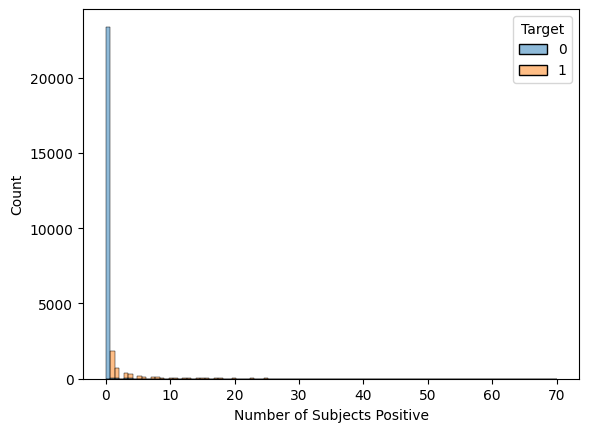

In [14]:
import seaborn as sns
sns.histplot(iedb_df[(iedb_df["Number of Subjects Tested"]>=1)&(iedb_df["Number of Subjects Tested"]<100)], x="Number of Subjects Positive", bins=100, hue="Target")

<Axes: xlabel='Distr. Mean', ylabel='Count'>

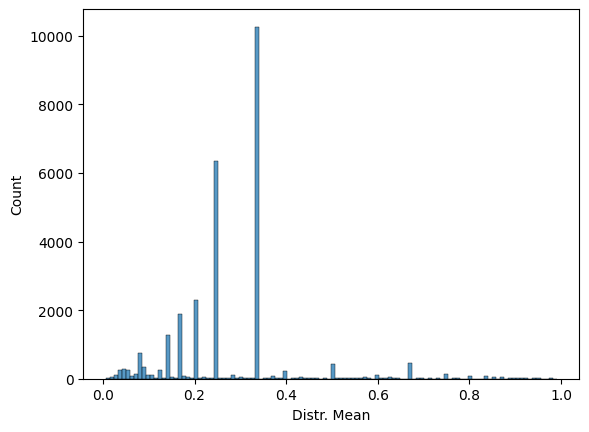

In [13]:
sns.histplot(iedb_df, x="Distr. Mean")

In [8]:
from selfpeptide.utils.training_utils import eval_classification_metrics
def find_optimal_class_threshold(df, target_metric="F1"):
    best_metric = 0
    best_threshold = 0.0
    for class_threshold in np.linspace(0.01, 0.51, 51):
        metrics = eval_classification_metrics(df["Target"], df["Distr. Mode"], is_logit=False, threshold=class_threshold)
        if metrics[target_metric]>best_metric:
            best_metric = metrics[target_metric]
            best_threshold = class_threshold
    return best_threshold



In [7]:
find_optimal_class_threshold(train_df)

0.01

In [8]:
eval_classification_metrics(train_df["Target"], train_df["Distr. Mode"], is_logit=False, threshold=0.01)

{'MCC': 0.9715482783547295,
 'FPR': 0.00884906808251756,
 'FNR': 0.0017889087656529517,
 'Specificity': 0.9911509319174825,
 'NPV': 0.9996653093099793,
 'FDR': 0.04561003420752566,
 'Precision': 0.9543899657924744,
 'Recall': 0.998211091234347,
 'F1': 0.9758088020985135,
 'BalancedAccuracy': 0.9946810115759148,
 'AUROC': 0.9961179133045271,
 'AUPRC': 0.9760883559631602}

In [9]:
# train_df, val_df, test_df, dhlap_df = load_immunogenicity_dataframes(config)

In [10]:
train_df
batch = train_df[["Peptide", "Allele Pseudo-sequence", "Allele Protein sequence"]].iloc[:10]
peptides = batch["Peptide"].tolist()
pseqs = batch["Allele Pseudo-sequence"].tolist()
prots = batch["Allele Protein sequence"].tolist()

In [11]:
# class ImmunogenicityBinaryClassifier(nn.Module):
#     def __init__(self, config, device, epsilon=1e-3):
#         super().__init__()
#         self.config = config
#         self.device = device
#         self.epsilon = epsilon
        
#         self.joint_mlp = ResMLP_Network(config, device)
        

#     def forward(self, binding_score, binding_peptides_embs, binding_hlas_embs, *args):
#         peptide_imm_embs = self.immunogenicity_aa_embedder(peptides)
#         hla_imm_embs = self.immunogenicity_aa_embedder(hlas)
#         mlp_input = torch.cat([binding_peptides_embs, binding_hlas_embs, 
#                                sns_peptides_embs, peptide_imm_embs, 
#                                hla_imm_embs], dim=1)
        
#         mlp_output = self.joint_mlp(mlp_input)
#         return mlp_output
    
class ImmunogenicityBetaModel(nn.Module):
    def __init__(self, config, device="cpu", epsilon=1e-3):
        super().__init__()
        self.config = config
        self.device = device
        self.epsilon = epsilon
        # assert config["output_dim"]==2, "Beta model requires 2 outputs"
        
        self.joint_mlp = ResMLP_Network(config, device)
        self.relu = nn.ReLU()
        

    def forward(self, binding_score_logit, binding_peptides_embs, binding_hlas_embs, *args):
        binding_score = torch.sigmoid(binding_score_logit).view(-1)
        mlp_input = torch.cat([binding_score.view(-1,1), binding_peptides_embs, binding_hlas_embs], dim=1)
        
        mlp_output = self.joint_mlp(mlp_input)
        
        means = self.epsilon + (1-2*self.epsilon) * torch.sigmoid(mlp_output[:, 0])
        posterior_means = binding_score * means
        precisions = 2 + torch.exp(mlp_output[:, 1])
        
        return torch.hstack([means.view(-1,1), posterior_means.view(-1,1), precisions.view(-1,1)])
    
    
class JointPeptidesNetwork_Classifier(nn.Module):
    def __init__(self, imm_config, binding_config, binding_checkpoint=None, device="cpu"):
        super().__init__()
        if not isinstance(binding_config, dict):
            with open(binding_config, "r") as f:
                binding_config = json.load(f)
        binding_config["pretrained_aa_embeddings"] = "none"
        
        self.binding_model = Peptide_HLA_BindingClassifier(binding_config, device=device) 
        if binding_checkpoint is not None:
            self.binding_model.load_state_dict(torch.load(binding_checkpoint, map_location=device))
        else:
            warnings.warn("Binding model not initialized")
        self.binding_model.eval()
        
        
        # Freeze binding model
        for p in self.binding_model.parameters():
            p.requires_grad = False

        self.immunogenicity_model = ImmunogenicityBetaModel(imm_config, device=device)
        self.immunogenicity_model.train()
    
    def forward(self, peptides, hla_pseudoseqs, hla_prots, *args):
        binding_score_logit, (binding_peptides_embs, binding_hlas_embs) = self.binding_model(peptides, hla_pseudoseqs, hla_prots)
        output = self.immunogenicity_model(binding_score_logit, binding_peptides_embs, binding_hlas_embs)
        return torch.hstack([torch.sigmoid(binding_score_logit).view(-1,1), output])

In [12]:
ic_config = {"mlp_input_dim": 1025,
             "mlp_hidden_dim": 2048,
             "mlp_num_layers": 2,
             "output_dim": 2
            }

In [13]:
model = JointPeptidesNetwork_Classifier(ic_config, binding_config, binding_checkpoint="../trained_models/BindingModels/solar-sweep-1/checkpoints/001_checkpoint.pt")

In [14]:
predictions = model(peptides, pseqs, prots)
predictions

tensor([[ 0.8655,  0.9070,  0.7850,  7.4825],
        [ 0.5128,  0.3524,  0.1807,  4.8193],
        [ 0.8530,  0.3729,  0.3181,  5.5152],
        [ 0.7471,  0.7325,  0.5472,  5.1689],
        [ 0.8572,  0.6505,  0.5576,  4.8091],
        [ 0.8076,  0.8319,  0.6718,  7.1383],
        [ 0.3602,  0.9680,  0.3487,  4.3311],
        [ 0.5098,  0.9367,  0.4776,  5.7508],
        [ 0.9163,  0.4457,  0.4084,  3.7293],
        [ 0.5474,  0.9586,  0.5247, 13.8320]], grad_fn=<CatBackward0>)

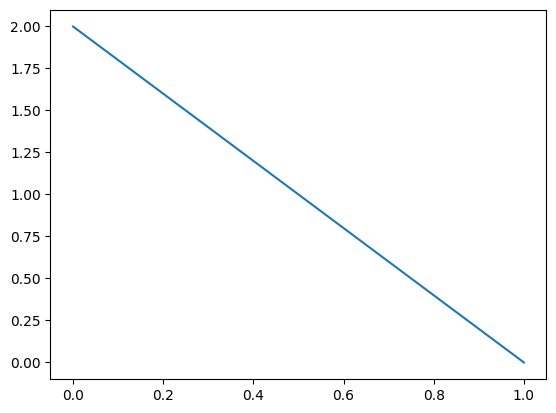

In [15]:
import matplotlib.pyplot as plt
xx = np.linspace(0, 1, 100)
yy = beta.pdf(xx, 1, 2)
plt.plot(xx, yy)

In [16]:
from selfpeptide.utils.beta_distr_utils import *
class BetaChernoffDistance(nn.Module):
    def __init__(self, config={}, device="cpu"):
        super().__init__()
        self.device = device
        self.lbd = config.get("chernoff_lambda", 0.5)
        self.loss_weights = config.get("loss_weights", "uniform")
        
        assert self.lbd>0 and self.lbd<1, "Select a valid lambda parameter"

    def forward(self, predictions, target_alphas, target_betas):
        logs = {}
        means = predictions[:,1]
        precisions = predictions[:, 3]
        
        alphas, betas, variances, modes = beta_distr_params_from_mean_precision(means, precisions)
        
        loss = beta_chernoff_distance(target_alphas, target_betas, alphas, betas, lbd=self.lbd)
        
        if self.loss_weights == "uniform":
            weight = torch.ones_like(loss).to(self.device)
        
        logs["unweighted_loss"] =  torch.mean(loss).item()
        loss = torch.mean(loss * weight)
 
        logs["loss"] =  loss.item()
        return loss, logs

In [17]:
batch

,Peptide,Allele Pseudo-sequence,Allele Protein sequence
18101,KVIALATEDK,YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
6632,LEYSISNDL,YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...
8003,TTWEDVPYL,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
14414,KEKAKEMNAL,YHTKYREISTNTYESNLYLRYNYYSLAVLAYEWY,MRVTAPRTVLLLLSAALALTETWAGSHSMRYFHTAMSRPGRGEPRF...
12127,IEYAKLYVL,YHTKYREISTNTYESNLYLSYNYYTWAVLAYEWY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...
14643,ALRFTSARR,YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
14554,KFANVSDEY,YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...
26877,RFTIGRALFK,YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWY,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFTTSVSRPGRGEPRF...
11666,KEFVQLFRVF,YHTKYREISTNTYESNLYLSYNYYTWAVLAYEWY,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...
8901,LVQRVTSVWR,YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...


In [18]:
batch_targets = train_df[["Alpha", "Beta"]].iloc[:10]
batch_targets

,Alpha,Beta
18101,1.0,2.0
6632,1.0,5.0
8003,5.0,1.0
14414,1.0,3.0
12127,1.0,3.0
14643,2.0,2.0
14554,1.0,3.0
26877,1.0,2.0
11666,1.0,3.0
8901,1.0,4.0


In [19]:
loss = BetaChernoffDistance()

In [20]:
target_alphas = torch.tensor(batch_targets["Alpha"].values)
target_betas = torch.tensor(batch_targets["Beta"].values)

In [21]:
loss(predictions, target_alphas, target_betas)

(tensor(1.0516, dtype=torch.float64, grad_fn=<MeanBackward0>),
 {'unweighted_loss': 1.0516343140869635, 'loss': 1.0516343140869635})

In [22]:
means = predictions[:,1]
precisions = predictions[:,3]

In [25]:
means


tensor([0.9070, 0.3524, 0.3729, 0.7325, 0.6505, 0.8319, 0.9680, 0.9367, 0.4457,
        0.9586], grad_fn=<SelectBackward0>)

In [26]:
precisions

tensor([ 7.4825,  4.8193,  5.5152,  5.1689,  4.8091,  7.1383,  4.3311,  5.7508,
         3.7293, 13.8320], grad_fn=<SelectBackward0>)

In [23]:
from selfpeptide.utils.beta_distr_utils import *
# def beta_distr_params_from_mean_precision(mean, precision):
#     alpha = mean * precision
#     beta = precision - alpha
    
#     variance = mean*(1-mean)/(1+precision)
    
#     mode = (alpha-1)/(alpha+beta-2)
#     # if alpha>1 and beta>1:
#     #     mode = (alpha-1)/(alpha+beta-2)
#     # elif alpha<=1 and beta>1:
#     #     mode = 0
#     # elif alpha>1 and beta<=1:
#     #     mode = 1
        
#     return alpha, beta, variance, mode

beta_distr_params_from_mean_precision(means, precisions)

(tensor([ 6.7866,  1.6983,  2.0566,  3.7861,  3.1282,  5.9383,  4.1926,  5.3866,
          1.6620, 13.2590], grad_fn=<MulBackward0>),
 tensor([0.6959, 3.1210, 3.4586, 1.3829, 1.6809, 1.2000, 0.1384, 0.3642, 2.0673,
         0.5730], grad_fn=<SubBackward0>),
 tensor([0.0099, 0.0392, 0.0359, 0.0318, 0.0391, 0.0172, 0.0058, 0.0088, 0.0522,
         0.0027], grad_fn=<DivBackward0>),
 tensor([1.0555, 0.2477, 0.3006, 0.8792, 0.7576, 0.9611, 1.3696, 1.1695, 0.3828,
         1.0361], grad_fn=<DivBackward0>))

In [24]:
beta_distr_params_from_alpha_beta(target_alphas, target_betas)

(tensor([0.3333, 0.1667, 0.8333, 0.2500, 0.2500, 0.5000, 0.2500, 0.3333, 0.2500,
         0.2000], dtype=torch.float64),
 tensor([3., 6., 6., 4., 4., 4., 4., 3., 4., 5.], dtype=torch.float64),
 tensor([0.0556, 0.0198, 0.0198, 0.0375, 0.0375, 0.0500, 0.0375, 0.0556, 0.0375,
         0.0267], dtype=torch.float64),
 tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
         0.0000], dtype=torch.float64))